In [2]:
import numpy as np
import pandas as pd
import math
from matplotlib import pyplot as plt
import ipywidgets as widgets
from matplotlib.patches import Rectangle

In [3]:
# Generating binned data:

# st_samp = np.squeeze(np.load("../../data/spike_times.npy")) # spike times file
# sc = np.squeeze(np.load("../../data/spike_clusters.npy"))
# st_s = st_samp / 3e4 # convert from 30khz samples to seconds
# # set up bin edges - 20 ms here
# bins_s = np.arange(np.min(st_s), np.max(st_s), 0.02)
# # make list of lists for spike times specific to each cluster
# spikes = [st_s[sc == clu] for clu in np.unique(sc)]
# # bin
# spk_mat = []
# for clu in spikes:
#     counts, _ = np.histogram(clu, bins_s)
#     spk_mat.append(counts)
# spk_mat = np.array(spk_mat) # should be [#neurons, #bins]
# # and your timestamps are the left bin edges, e.g. plot avg pop rate over time
# plt.plot(bins_s[:-1], np.mean(spk_mat, axis=0))

In [4]:
#Pulling in pre binned data to combine w ids

ids = np.load("../../data/spike_clusters.npy")
binned_spikes = np.load("../../data/binned_20ms.npy")
spike_data =  pd.DataFrame(binned_spikes)
spike_data

,0,1,2,3,4,5,6,7,8,9,...,161525,161526,161527,161528,161529,161530,161531,161532,161533,161534
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
774,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
775,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
776,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
777,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
# To pull out stim data
stim_on_time = np.load("../../data/natImsOnTimes.npy")
stim_on_time
#to bin: divide by 20, floor
stim_binned = np.floor(stim_on_time*1000 /20)
stim_binned = np.transpose(stim_binned)
stim_ids = np.load("../../data/natImsIDs.npy") # max is 10
stims = np.vstack((stim_binned, stim_ids))
stims = pd.DataFrame(stims)
stims.columns = stims.iloc[0]
stims = stims.drop(0)
# stims = stims.rename(index={1: 'stim'})

#stims = stims.T.sort_values(by = 0).T
stims
# stim_ids

,12548.0,12579.0,12655.0,12699.0,12748.0,12852.0,12889.0,12928.0,12969.0,13014.0,...,87027.0,87065.0,87119.0,87173.0,87218.0,87264.0,87302.0,87360.0,87414.0,87490.0
1,9.0,9.0,5.0,1.0,2.0,4.0,3.0,10.0,3.0,9.0,...,7.0,9.0,1.0,10.0,10.0,2.0,5.0,9.0,2.0,1.0


In [35]:
bin_pre_average = pd.DataFrame()  # Initialize an empty DataFrame
average_across_bins = pd.DataFrame()
# Iterate through each bin_id
#for i in range(len(stims.columns)):
    #bin_id = int(stims.columns[i])
bin_id = 12548
    # Select the columns of time snippet we are using
selected_columns = spike_data.iloc[:,bin_id - 5: bin_id + 26]

bin_average = selected_columns.mean(axis=0).to_frame().T  # Compute the means of all the neurons for one stimulus into a single row df


# Concatenate bin_average vertically to average_across_bins
average_across_bins = pd.concat([average_across_bins, bin_average], axis=0)




average_across_bins #average the values in each column and store in a row here


,12543,12544,12545,12546,12547,12548,12549,12550,12551,12552,...,12564,12565,12566,12567,12568,12569,12570,12571,12572,12573
0,0.008986,0.017972,0.014121,0.01027,0.020539,0.029525,0.008986,0.002567,0.002567,0.002567,...,0.023107,0.029525,0.038511,0.020539,0.007702,0.002567,0.006418,0.012837,0.012837,0.006418


In [14]:
# Combining the dfs
combined = spike_data.merge(stims, how = "outer")
combined = combined.rename(index={799: 'stim'})
combined

,0,1,2,3,4,5,6,7,8,9,...,161525,161526,161527,161528,161529,161530,161531,161532,161533,161534
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
775,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
776,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
777,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


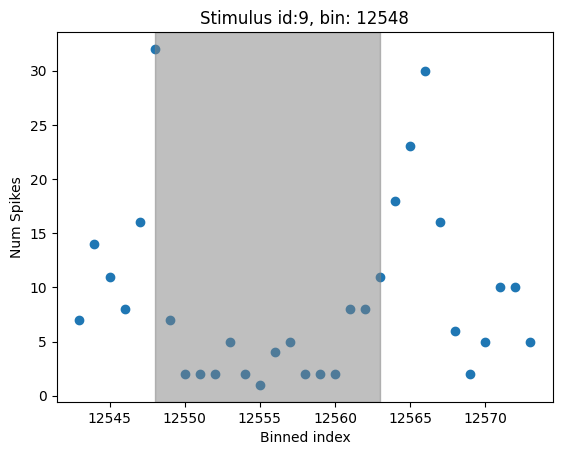

In [15]:
bin_id = 12548
stim_id = int(combined.iloc[779,bin_id])
# Assuming combined is your DataFrame
x = combined.columns[bin_id - 5: bin_id + 26].to_list()  # Adjusted slicing indices
#x = [i * 20 for i in x]
y = combined.iloc[:, bin_id - 5: bin_id + 26].sum().to_list()  # Adjusted slicing indices

plt.scatter(x, y)
plt.xlabel('Binned index')
plt.ylabel('Num Spikes')
plt.title('Stimulus id:{}, bin: {}'.format(stim_id, bin_id))

# Add the gray rectangle
plt.axvspan(bin_id, bin_id + 15, color='gray', alpha=0.5)

plt.show()


In [3]:
allen = pd.read_csv("../../data/allen_visual_behavior_firing_rate.csv")
allen = allen.iloc[::400]


In [133]:
def slope_viz_neurons(t=0):
    t = int(t)
    if t<25:
        x = spike_data.columns[0:25].to_list()
        y = spike_data.iloc[:,0:25].sum().to_list()
    else:
        x = spike_data.columns[t-50:t+50].to_list()
        y = spike_data.iloc[:,t-50:t+50].sum().to_list()
    plt.scatter(x, y, label='Spikes')
    plt.axvline(t, color='red', linestyle='--',)
    plt.xlabel('Time(in 20ms bins)')
    plt.ylabel('Num Spikes')
    plt.legend()
    plt.show()
    print(len(x))
    print(len(y))

probably smoother to have the line move than to have the entire graph move, maybe pass in edges of the graphs as parameters?
def add more widget functions to the ui to clean it up
need to combine with image dataset, maybe transparent boxes or something?
should data be put into bigger bins?

In [134]:
slider = widgets.FloatSlider(value=0.0, min=0.0, max=500.0, step=5.0, description='Time')
slider.layout.width = "100%"
widgets.interact(slope_viz_neurons, t=slider)

interactive(children=(FloatSlider(value=0.0, description='Time', layout=Layout(width='100%'), max=500.0, step=…

<function __main__.slope_viz_neurons(t=0)>